In [1]:
ASSET = "SOLUSDT"
TARGET = "Close"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,179.06,634599.39,Extreme Fear,0.051981,0.040752,46.954810,18.002996,-3.72,9.27,9.19,-0.08,0.517269,0.001626,-0.473868,180.428571,182.025000
2022-01-02,176.35,620087.38,Fear,-0.015250,0.040740,45.504719,17.743547,-3.58,5.22,0.47,-4.75,0.504927,0.001610,-0.705077,177.362857,181.769286
2022-01-03,170.15,1031316.43,Fear,-0.035790,0.040847,42.287130,18.082047,-3.75,9.90,0.15,-9.75,0.520939,0.001411,-1.296484,173.717143,181.501429
2022-01-04,167.72,1041332.63,Extreme Fear,-0.014384,0.039753,41.061641,18.405135,-11.91,7.46,3.79,-3.67,0.487316,0.001499,-1.751934,172.345714,180.650714
2022-01-05,154.52,1659848.17,Extreme Fear,-0.081972,0.044788,35.109438,20.001075,-23.88,26.40,3.58,-22.82,0.468254,0.001723,-2.572725,170.044286,178.945000


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:49,666] A new study created in memory with name: no-name-64b6b06e-c13a-42ed-86ba-0310a17f70f2
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0591 - val_loss: 0.0263
Epoch 2/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0105 - val_loss: 0.0232
Epoch 3/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093 - val_loss: 0.0311
Epoch 4/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0087 - val_loss: 0.0345
Epoch 5/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0088 - val_loss: 0.0296
Epoch 6/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0073 - val_loss: 0.0333
Epoch 7/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0066 - val_loss: 0.0382
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-05-09 19:33:58,379] Trial 0 finished with value: 1417.6727013981017 and parameters: {'units_l0': 130, 'dropout_l0': 0.4110675393700543, 'learning_rate': 0.002517182359396691, 'batch_size': 64, 'max_epochs': 23, 'sequence_length': 40}. Best is trial 0 with value: 1417.6727013981017.


Epoch 1/57


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.5531 - val_loss: 1.2657
Epoch 2/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4128 - val_loss: 1.0111
Epoch 3/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2902 - val_loss: 0.8050
Epoch 4/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2151 - val_loss: 0.6370
Epoch 5/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1370 - val_loss: 0.5031
Epoch 6/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0995 - val_loss: 0.3948
Epoch 7/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0627 - val_loss: 0.3106
Epoch 8/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0432 - val_loss: 0.2474
Epoch 9/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0340 - val_loss: 0.2001
Epoch 10/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0239 - val_loss: 0.1675
Epoch 11/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0216 - val_loss: 0.1432
Epoch 12/57
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0175 - val_l

[I 2025-05-09 19:34:23,254] Trial 1 finished with value: 1350.7454136649285 and parameters: {'units_l0': 120, 'dropout_l0': 0.010129240975217446, 'learning_rate': 2.8674691417890424e-05, 'batch_size': 64, 'max_epochs': 57, 'sequence_length': 14}. Best is trial 1 with value: 1350.7454136649285.


Epoch 1/17


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.4052 - val_loss: 0.0224
Epoch 2/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0028 - val_loss: 0.0097
Epoch 3/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0139
Epoch 4/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 5/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023 - val_loss: 0.0126
Epoch 6/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023 - val_loss: 0.0201
Epoch 7/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0232
Epoch 8/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0163
Epoch 9/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 0.0148
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-05-09 19:34:36,247] Trial 2 finished with value: 347.5169506195241 and parameters: {'units_l0': 119, 'dropout_l0': 0.10466779532359405, 'learning_rate': 0.00857242749569684, 'batch_size': 16, 'max_epochs': 17, 'sequence_length': 30}. Best is trial 2 with value: 347.5169506195241.


Epoch 1/62


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0856 - val_loss: 0.3849
Epoch 2/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0751 - val_loss: 0.3286
Epoch 3/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0670 - val_loss: 0.2810
Epoch 4/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0535 - val_loss: 0.2451
Epoch 5/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0450 - val_loss: 0.2162
Epoch 6/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0446 - val_loss: 0.1913
Epoch 7/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0335 - val_loss: 0.1729
Epoch 8/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0325 - val_loss: 0.1566
Epoch 9/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0295 - val_loss: 0.1434
Epoch 10/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0281 - val_loss: 0.1334
Epoch 11/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0249 - val_loss: 0.1259
Epoch 12/62
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0229 - val_l

[I 2025-05-09 19:35:11,822] Trial 3 finished with value: 1061.7227171536733 and parameters: {'units_l0': 107, 'dropout_l0': 0.20893682746117337, 'learning_rate': 1.418854061865112e-05, 'batch_size': 64, 'max_epochs': 62, 'sequence_length': 45}. Best is trial 2 with value: 347.5169506195241.


Epoch 1/99


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0485 - val_loss: 0.0659
Epoch 2/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0124 - val_loss: 0.0235
Epoch 3/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0083 - val_loss: 0.0221
Epoch 4/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0067 - val_loss: 0.0181
Epoch 5/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0068 - val_loss: 0.0194
Epoch 6/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0066 - val_loss: 0.0212
Epoch 7/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0051 - val_loss: 0.0254
Epoch 8/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0053 - val_loss: 0.0166
Epoch 9/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0061 - val_loss: 0.0247
Epoch 10/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0047 - val_loss: 0.0267
Epoch 11/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0052 - val_loss: 0.0274
Epoch 12/99
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0054 - val

[I 2025-05-09 19:35:31,718] Trial 4 finished with value: 1016.4053083456599 and parameters: {'units_l0': 187, 'dropout_l0': 0.2949092456016538, 'learning_rate': 0.0002491464465550555, 'batch_size': 64, 'max_epochs': 99, 'sequence_length': 46}. Best is trial 2 with value: 347.5169506195241.


Epoch 1/41


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0413 - val_loss: 0.1328
Epoch 2/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0232 - val_loss: 0.0722
Epoch 3/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0164 - val_loss: 0.0441
Epoch 4/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0099 - val_loss: 0.0274
Epoch 5/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0089 - val_loss: 0.0201
Epoch 6/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0060 - val_loss: 0.0174
Epoch 7/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0066 - val_loss: 0.0198
Epoch 8/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0070 - val_loss: 0.0242
Epoch 9/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0062 - val_loss: 0.0195
Epoch 10/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0061 - val_loss: 0.0189
Epoch 11/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0068 - val_loss: 0.0158
Epoch 12/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0050 - val_

[I 2025-05-09 19:36:12,761] Trial 5 finished with value: 966.6964725034086 and parameters: {'units_l0': 190, 'dropout_l0': 0.26731151908937756, 'learning_rate': 2.3246370593171165e-05, 'batch_size': 16, 'max_epochs': 41, 'sequence_length': 59}. Best is trial 2 with value: 347.5169506195241.


Epoch 1/74


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0756 - val_loss: 0.0226
Epoch 2/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0052 - val_loss: 0.0166
Epoch 3/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - val_loss: 0.0197
Epoch 4/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0056 - val_loss: 0.0264
Epoch 5/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0047 - val_loss: 0.0501
Epoch 6/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - val_loss: 0.0376
Epoch 7/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040 - val_loss: 0.0341
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-05-09 19:36:30,346] Trial 6 finished with value: 1013.314737395064 and parameters: {'units_l0': 151, 'dropout_l0': 0.24293168482923583, 'learning_rate': 0.004108933594887076, 'batch_size': 16, 'max_epochs': 74, 'sequence_length': 40}. Best is trial 2 with value: 347.5169506195241.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0755 - val_loss: 0.0509
Epoch 2/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0148 - val_loss: 0.0127
Epoch 3/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0075 - val_loss: 0.0125
Epoch 4/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0067 - val_loss: 0.0126
Epoch 5/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0063 - val_loss: 0.0169
Epoch 6/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0047 - val_loss: 0.0160
Epoch 7/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0052 - val_loss: 0.0188
Epoch 8/91
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0048 - val_loss: 0.0174
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


[I 2025-05-09 19:36:43,814] Trial 7 finished with value: 762.2640286928421 and parameters: {'units_l0': 135, 'dropout_l0': 0.21312792440060807, 'learning_rate': 0.00036538752301948943, 'batch_size': 64, 'max_epochs': 91, 'sequence_length': 51}. Best is trial 2 with value: 347.5169506195241.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0353 - val_loss: 0.0092
Epoch 2/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 3/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0095
Epoch 4/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 0.0091
Epoch 5/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 6/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 7/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012 - val_loss: 0.0071
Epoch 8/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.9178e-04 - val_loss: 0.0072
Epoch 9/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.1880e-04 - val_loss: 0.0093
Epoch 10/71
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.0774e-04 - val_loss: 0.0065
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-05-09 19:36:59,531] Trial 8 finished with value: 306.90193299778093 and parameters: {'units_l0': 55, 'dropout_l0': 0.031538047694596893, 'learning_rate': 0.003934745639129734, 'batch_size': 32, 'max_epochs': 71, 'sequence_length': 45}. Best is trial 8 with value: 306.90193299778093.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0156 - val_loss: 0.0163
Epoch 2/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0074 - val_loss: 0.0173
Epoch 3/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0072 - val_loss: 0.0209
Epoch 4/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0061 - val_loss: 0.0227
Epoch 5/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0067 - val_loss: 0.0237
Epoch 6/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0070 - val_loss: 0.0304
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2025-05-09 19:37:12,850] Trial 9 finished with value: 994.1599464646489 and parameters: {'units_l0': 174, 'dropout_l0': 0.35593638505980013, 'learning_rate': 0.00034109255535769433, 'batch_size': 32, 'max_epochs': 83, 'sequence_length': 32}. Best is trial 8 with value: 306.90193299778093.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0361 - val_loss: 0.0087
Epoch 2/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 0.0070
Epoch 3/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 4/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.5520e-04 - val_loss: 0.0065
Epoch 5/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 6/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.5270e-04 - val_loss: 0.0064
Epoch 7/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.3882e-04 - val_loss: 0.0040
Epoch 8/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 9/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.6395e-04 - val_loss: 0.0046
Epoch 10/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_loss: 0.0103
Epoch 11/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6754e-04 - val_loss: 0.0069
Epoch 12/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2

[I 2025-05-09 19:37:26,292] Trial 10 finished with value: 191.56920534969942 and parameters: {'units_l0': 58, 'dropout_l0': 0.026104582225140963, 'learning_rate': 0.0012117343657127616, 'batch_size': 32, 'max_epochs': 41, 'sequence_length': 23}. Best is trial 10 with value: 191.56920534969942.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0572 - val_loss: 0.0050
Epoch 2/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 3/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.7693e-04 - val_loss: 0.0042
Epoch 4/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4597e-04 - val_loss: 0.0059
Epoch 5/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1641e-04 - val_loss: 0.0103
Epoch 6/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.2615e-04 - val_loss: 0.0061
Epoch 7/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5021e-04 - val_loss: 0.0057
Epoch 8/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6159e-04 - val_loss: 0.0080
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2025-05-09 19:37:34,699] Trial 11 finished with value: 255.48288609212472 and parameters: {'units_l0': 53, 'dropout_l0': 0.0015488209419770582, 'learning_rate': 0.0014841700279624147, 'batch_size': 32, 'max_epochs': 41, 'sequence_length': 18}. Best is trial 10 with value: 191.56920534969942.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/36
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0971 - val_loss: 0.0187
Epoch 2/36
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066 - val_loss: 0.0082
Epoch 3/36
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0140
Epoch 4/36
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0102
Epoch 5/36
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0175
Epoch 6/36
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0148
Epoch 7/36
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0145
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-05-09 19:37:45,374] Trial 12 finished with value: 503.8006536944617 and parameters: {'units_l0': 54, 'dropout_l0': 0.10779690875450196, 'learning_rate': 0.0009242628728963612, 'batch_size': 32, 'max_epochs': 36, 'sequence_length': 17}. Best is trial 10 with value: 191.56920534969942.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0208 - val_loss: 0.0220
Epoch 2/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0031 - val_loss: 0.0133
Epoch 3/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 0.0182
Epoch 4/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0029 - val_loss: 0.0141
Epoch 5/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020 - val_loss: 0.0157
Epoch 6/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025 - val_loss: 0.0170
Epoch 7/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 0.0134
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2025-05-09 19:37:58,028] Trial 13 finished with value: 810.1128444895472 and parameters: {'units_l0': 83, 'dropout_l0': 0.10876494442068667, 'learning_rate': 0.0009173402418313476, 'batch_size': 32, 'max_epochs': 42, 'sequence_length': 23}. Best is trial 10 with value: 191.56920534969942.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0663 - val_loss: 0.1264
Epoch 2/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0201 - val_loss: 0.0376
Epoch 3/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0074 - val_loss: 0.0147
Epoch 4/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0116
Epoch 5/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 0.0096
Epoch 6/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026 - val_loss: 0.0105
Epoch 7/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 8/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 9/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_loss: 0.0093
Epoch 10/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0110
Epoch 11/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 0.0119
Epoch 12/27
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

[I 2025-05-09 19:38:10,719] Trial 14 finished with value: 521.3912026084763 and parameters: {'units_l0': 78, 'dropout_l0': 0.04277177792847034, 'learning_rate': 0.00011001350521065602, 'batch_size': 32, 'max_epochs': 27, 'sequence_length': 24}. Best is trial 10 with value: 191.56920534969942.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0541 - val_loss: 0.0257
Epoch 2/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0135 - val_loss: 0.0394
Epoch 3/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0101 - val_loss: 0.0259
Epoch 4/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0093 - val_loss: 0.0463
Epoch 5/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0098 - val_loss: 0.0227
Epoch 6/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0104 - val_loss: 0.0335
Epoch 7/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090 - val_loss: 0.0333
Epoch 8/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0078 - val_loss: 0.0615
Epoch 9/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0095 - val_loss: 0.0748
Epoch 10/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0081 - val_loss: 0.0642
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2025-05-09 19:38:22,747] Trial 15 finished with value: 1386.278369080668 and parameters: {'units_l0': 77, 'dropout_l0': 0.49678110842783785, 'learning_rate': 0.0011944965008640507, 'batch_size': 32, 'max_epochs': 48, 'sequence_length': 24}. Best is trial 10 with value: 191.56920534969942.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0479 - val_loss: 0.1600
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0255 - val_loss: 0.1033
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158 - val_loss: 0.0658
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0469
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0096 - val_loss: 0.0350
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - val_loss: 0.0346
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081 - val_loss: 0.0325
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - val_loss: 0.0278
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - val_loss: 0.0235
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - val_loss: 0.0224
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-05-09 19:38:31,756] Trial 16 finished with value: 1372.0366354744096 and parameters: {'units_l0': 50, 'dropout_l0': 0.16157381520400171, 'learning_rate': 0.00010485593065399741, 'batch_size': 32, 'max_epochs': 10, 'sequence_length': 18}. Best is trial 10 with value: 191.56920534969942.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0234 - val_loss: 0.0161
Epoch 2/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0099
Epoch 3/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5930e-04 - val_loss: 0.0052
Epoch 4/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.8376e-04 - val_loss: 0.0048
Epoch 5/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0613e-04 - val_loss: 0.0025
Epoch 6/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9233e-04 - val_loss: 0.0033
Epoch 7/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8444e-04 - val_loss: 0.0034
Epoch 8/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2386e-04 - val_loss: 0.0021
Epoch 9/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0470e-04 - val_loss: 0.0039
Epoch 10/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4830e-04 - val_loss: 0.0018
Epoch 11/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6180e-04 - val_loss: 0.0030
Epoch 12/32
28/28 ━━━━━━━━━

[I 2025-05-09 19:38:44,019] Trial 17 finished with value: 112.99256769105929 and parameters: {'units_l0': 95, 'dropout_l0': 0.000482761890723004, 'learning_rate': 0.002253613130811315, 'batch_size': 32, 'max_epochs': 32, 'sequence_length': 13}. Best is trial 17 with value: 112.99256769105929.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/26
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.2176 - val_loss: 0.0084
Epoch 2/26
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - val_loss: 0.0184
Epoch 3/26
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 4/26
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.0089
Epoch 5/26
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0118
Epoch 6/26
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 0.0174
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-05-09 19:38:52,750] Trial 18 finished with value: 511.0077322702996 and parameters: {'units_l0': 96, 'dropout_l0': 0.06565861465765858, 'learning_rate': 0.007797103685294695, 'batch_size': 32, 'max_epochs': 26, 'sequence_length': 10}. Best is trial 17 with value: 112.99256769105929.


Epoch 1/32


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0395 - val_loss: 0.0101
Epoch 2/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 3/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046 - val_loss: 0.0127
Epoch 4/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0159
Epoch 5/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0197
Epoch 6/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0115
Epoch 7/32
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0151
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


[I 2025-05-09 19:38:59,700] Trial 19 finished with value: 468.4877522525007 and parameters: {'units_l0': 92, 'dropout_l0': 0.15937975758992623, 'learning_rate': 0.0005097858546575742, 'batch_size': 32, 'max_epochs': 32, 'sequence_length': 11}. Best is trial 17 with value: 112.99256769105929.


Epoch 1/51


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0486 - val_loss: 0.0114
Epoch 2/51
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0126
Epoch 3/51
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0088
Epoch 4/51
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - val_loss: 0.0178
Epoch 5/51
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0022 - val_loss: 0.0175
Epoch 6/51
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 0.0158
Epoch 7/51
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 0.0122
Epoch 8/51
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.6961e-04 - val_loss: 0.0238
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-05-09 19:39:12,509] Trial 20 finished with value: 537.7802382466051 and parameters: {'units_l0': 67, 'dropout_l0': 0.07138993903499831, 'learning_rate': 0.0029264906258897145, 'batch_size': 16, 'max_epochs': 51, 'sequence_length': 31}. Best is trial 17 with value: 112.99256769105929.


Epoch 1/43


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0598 - val_loss: 0.0170
Epoch 2/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - val_loss: 0.0097
Epoch 3/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 4/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.2013e-04 - val_loss: 0.0090
Epoch 5/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.4198e-04 - val_loss: 0.0069
Epoch 6/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2757e-04 - val_loss: 0.0082
Epoch 7/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2179e-04 - val_loss: 0.0071
Epoch 8/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0463e-04 - val_loss: 0.0059
Epoch 9/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2050e-04 - val_loss: 0.0073
Epoch 10/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6594e-04 - val_loss: 0.0048
Epoch 11/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.9415e-04 - val_loss: 0.0069
Epoch 12/43
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:39:29,156] Trial 21 finished with value: 258.012815574502 and parameters: {'units_l0': 66, 'dropout_l0': 0.0022147303793847214, 'learning_rate': 0.001646719220830807, 'batch_size': 32, 'max_epochs': 43, 'sequence_length': 18}. Best is trial 17 with value: 112.99256769105929.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0351 - val_loss: 0.0239
Epoch 2/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0159
Epoch 3/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 4/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0144
Epoch 5/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0072
Epoch 6/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 0.0068
Epoch 7/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - val_loss: 0.0180
Epoch 8/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0195
Epoch 9/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 0.0132
Epoch 10/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0118
Epoch 11/35
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 0.0118
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-05-09 19:39:38,960] Trial 22 finished with value: 416.7771146709397 and parameters: {'units_l0': 65, 'dropout_l0': 0.06655033014234246, 'learning_rate': 0.002092494512650231, 'batch_size': 32, 'max_epochs': 35, 'sequence_length': 22}. Best is trial 17 with value: 112.99256769105929.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0547 - val_loss: 0.0042
Epoch 2/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 3/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.2477e-04 - val_loss: 0.0023
Epoch 4/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.7239e-04 - val_loss: 0.0026
Epoch 5/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.7994e-04 - val_loss: 0.0024
Epoch 6/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6162e-04 - val_loss: 0.0021
Epoch 7/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3094e-04 - val_loss: 0.0023
Epoch 8/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2293e-04 - val_loss: 0.0020
Epoch 9/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.1028e-04 - val_loss: 0.0021
Epoch 10/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1464e-04 - val_loss: 0.0018
Epoch 11/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.5819e-04 - val_loss: 0.0022
Epoch 12/61
27/27 ━━━━━━━━━

[I 2025-05-09 19:39:54,054] Trial 23 finished with value: 108.3796875910167 and parameters: {'units_l0': 95, 'dropout_l0': 0.00027321011039381526, 'learning_rate': 0.0006528802319811858, 'batch_size': 32, 'max_epochs': 61, 'sequence_length': 27}. Best is trial 23 with value: 108.3796875910167.


Epoch 1/63


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0540 - val_loss: 0.0106
Epoch 2/63
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052 - val_loss: 0.0252
Epoch 3/63
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031 - val_loss: 0.0156
Epoch 4/63
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0181
Epoch 5/63
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0027 - val_loss: 0.0166
Epoch 6/63
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039 - val_loss: 0.0181
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


[I 2025-05-09 19:40:05,932] Trial 24 finished with value: 645.5702865445209 and parameters: {'units_l0': 104, 'dropout_l0': 0.1507690789472718, 'learning_rate': 0.000680894641096114, 'batch_size': 32, 'max_epochs': 63, 'sequence_length': 29}. Best is trial 23 with value: 108.3796875910167.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1373 - val_loss: 0.1105
Epoch 2/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0257 - val_loss: 0.0639
Epoch 3/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0072 - val_loss: 0.0297
Epoch 4/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052 - val_loss: 0.0240
Epoch 5/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0039 - val_loss: 0.0207
Epoch 6/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0040 - val_loss: 0.0199
Epoch 7/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - val_loss: 0.0197
Epoch 8/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0030 - val_loss: 0.0166
Epoch 9/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0166
Epoch 10/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020 - val_loss: 0.0144
Epoch 11/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020 - val_loss: 0.0121
Epoch 12/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

[I 2025-05-09 19:40:30,675] Trial 25 finished with value: 475.7742930153762 and parameters: {'units_l0': 107, 'dropout_l0': 0.051666367737796925, 'learning_rate': 0.00012187321117289393, 'batch_size': 32, 'max_epochs': 56, 'sequence_length': 26}. Best is trial 23 with value: 108.3796875910167.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0365 - val_loss: 0.0261
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0049 - val_loss: 0.0120
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0035 - val_loss: 0.0133
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034 - val_loss: 0.0157
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0028 - val_loss: 0.0151
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0027 - val_loss: 0.0189
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0024 - val_loss: 0.0120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-05-09 19:40:43,363] Trial 26 finished with value: 735.27363837986 and parameters: {'units_l0': 144, 'dropout_l0': 0.11647965191153346, 'learning_rate': 0.0002040286093779802, 'batch_size': 32, 'max_epochs': 70, 'sequence_length': 35}. Best is trial 23 with value: 108.3796875910167.


Epoch 1/49


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0619 - val_loss: 0.0131
Epoch 2/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0144
Epoch 3/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 4/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 0.0093
Epoch 5/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 0.0085
Epoch 6/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 7/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.6538e-04 - val_loss: 0.0047
Epoch 8/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.2027e-04 - val_loss: 0.0123
Epoch 9/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0553e-04 - val_loss: 0.0046
Epoch 10/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8203e-04 - val_loss: 0.0060
Epoch 11/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9133e-04 - val_loss: 0.0081
Epoch 12/49
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

[I 2025-05-09 19:40:56,124] Trial 27 finished with value: 282.7187175858763 and parameters: {'units_l0': 89, 'dropout_l0': 0.032193691087114215, 'learning_rate': 0.005319829586359275, 'batch_size': 32, 'max_epochs': 49, 'sequence_length': 14}. Best is trial 23 with value: 108.3796875910167.


Epoch 1/17


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0698 - val_loss: 0.0992
Epoch 2/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0186 - val_loss: 0.0495
Epoch 3/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0093 - val_loss: 0.0197
Epoch 4/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0055 - val_loss: 0.0127
Epoch 5/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0096
Epoch 6/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - val_loss: 0.0096
Epoch 7/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0031 - val_loss: 0.0075
Epoch 8/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - val_loss: 0.0087
Epoch 9/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0027 - val_loss: 0.0086
Epoch 10/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - val_loss: 0.0093
Epoch 11/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 0.0108
Epoch 12/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - val_l

[I 2025-05-09 19:41:14,957] Trial 28 finished with value: 457.22189859377596 and parameters: {'units_l0': 102, 'dropout_l0': 0.09110852035603048, 'learning_rate': 5.4412713482249186e-05, 'batch_size': 16, 'max_epochs': 17, 'sequence_length': 28}. Best is trial 23 with value: 108.3796875910167.


Epoch 1/30


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0593 - val_loss: 0.0394
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0101 - val_loss: 0.0273
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0095 - val_loss: 0.0287
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0064 - val_loss: 0.0267
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0065 - val_loss: 0.0292
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0066 - val_loss: 0.0471
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0069 - val_loss: 0.0501
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0056 - val_loss: 0.0351
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0051 - val_loss: 0.0398
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-05-09 19:41:31,013] Trial 29 finished with value: 1630.8666733280268 and parameters: {'units_l0': 129, 'dropout_l0': 0.4007638590597342, 'learning_rate': 0.0006788105974351724, 'batch_size': 32, 'max_epochs': 30, 'sequence_length': 37}. Best is trial 23 with value: 108.3796875910167.


Epoch 1/80


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0371 - val_loss: 0.0095
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0067 - val_loss: 0.0141
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0043 - val_loss: 0.0196
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036 - val_loss: 0.0110
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0034 - val_loss: 0.0091
Epoch 6/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032 - val_loss: 0.0171
Epoch 7/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030 - val_loss: 0.0124
Epoch 8/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0027 - val_loss: 0.0149
Epoch 9/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0032 - val_loss: 0.0105
Epoch 10/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030 - val_loss: 0.0179
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-05-09 19:41:41,799] Trial 30 finished with value: 556.192049172537 and parameters: {'units_l0': 116, 'dropout_l0': 0.13918463065177222, 'learning_rate': 0.0005950164335015966, 'batch_size': 64, 'max_epochs': 80, 'sequence_length': 20}. Best is trial 23 with value: 108.3796875910167.


Epoch 1/39


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0169 - val_loss: 0.0158
Epoch 2/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - val_loss: 0.0117
Epoch 3/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.2268e-04 - val_loss: 0.0048
Epoch 4/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0182e-04 - val_loss: 0.0054
Epoch 5/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2327e-04 - val_loss: 0.0055
Epoch 6/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.2623e-04 - val_loss: 0.0024
Epoch 7/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8368e-04 - val_loss: 0.0052
Epoch 8/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1903e-04 - val_loss: 0.0032
Epoch 9/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5358e-04 - val_loss: 0.0016
Epoch 10/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7975e-04 - val_loss: 0.0031
Epoch 11/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.6481e-04 - val_loss: 0.0046
Epoch 12/39
28/28 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:41:53,825] Trial 31 finished with value: 96.07776814230795 and parameters: {'units_l0': 68, 'dropout_l0': 0.001746357922424084, 'learning_rate': 0.0014860062091742736, 'batch_size': 32, 'max_epochs': 39, 'sequence_length': 14}. Best is trial 31 with value: 96.07776814230795.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0263 - val_loss: 0.0299
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - val_loss: 0.0113
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0100
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 0.0112
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4043e-04 - val_loss: 0.0102
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0081
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4856e-04 - val_loss: 0.0049
Epoch 9/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 10/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 0.0113
Epoch 11/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8347e-04 - val_loss: 0.0095
Epoch 12/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

[I 2025-05-09 19:42:05,347] Trial 32 finished with value: 300.04847736066364 and parameters: {'units_l0': 74, 'dropout_l0': 0.026251961776050676, 'learning_rate': 0.00195048012613707, 'batch_size': 32, 'max_epochs': 60, 'sequence_length': 14}. Best is trial 31 with value: 96.07776814230795.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0421 - val_loss: 0.0107
Epoch 2/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0152
Epoch 3/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3465e-04 - val_loss: 0.0120
Epoch 4/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6236e-04 - val_loss: 0.0127
Epoch 5/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0635e-04 - val_loss: 0.0082
Epoch 6/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5521e-04 - val_loss: 0.0058
Epoch 7/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0259e-04 - val_loss: 0.0064
Epoch 8/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7652e-04 - val_loss: 0.0065
Epoch 9/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6671e-04 - val_loss: 0.0044
Epoch 10/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9438e-04 - val_loss: 0.0048
Epoch 11/52
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.2391e-04 - val_loss: 0.0055
Epoch 12/52
28/28 ━━━━━━━━━

[I 2025-05-09 19:42:20,162] Trial 33 finished with value: 267.6511145457645 and parameters: {'units_l0': 63, 'dropout_l0': 0.0019615070469427964, 'learning_rate': 0.002885843865969361, 'batch_size': 32, 'max_epochs': 52, 'sequence_length': 13}. Best is trial 31 with value: 96.07776814230795.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0265 - val_loss: 0.0176
Epoch 2/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - val_loss: 0.0179
Epoch 3/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.0122
Epoch 4/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_loss: 0.0117
Epoch 5/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 6/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - val_loss: 0.0083
Epoch 7/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0188
Epoch 8/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 0.0182
Epoch 9/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0168
Epoch 10/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0217
Epoch 11/21
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 0.0262
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2025-05-09 19:42:31,116] Trial 34 finished with value: 509.11424229249445 and parameters: {'units_l0': 83, 'dropout_l0': 0.08249138615947474, 'learning_rate': 0.0011317962293263101, 'batch_size': 32, 'max_epochs': 21, 'sequence_length': 26}. Best is trial 31 with value: 96.07776814230795.


Epoch 1/38


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.1263 - val_loss: 0.0236
Epoch 2/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 3/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 4/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0014 - val_loss: 0.0064
Epoch 5/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 6/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 7/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0011 - val_loss: 0.0064
Epoch 8/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.1753e-04 - val_loss: 0.0059
Epoch 9/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.7137e-04 - val_loss: 0.0041
Epoch 10/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 11/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.001

[I 2025-05-09 19:42:45,359] Trial 35 finished with value: 253.1619317029164 and parameters: {'units_l0': 115, 'dropout_l0': 0.03243089938983461, 'learning_rate': 0.006524743501200878, 'batch_size': 64, 'max_epochs': 38, 'sequence_length': 21}. Best is trial 31 with value: 96.07776814230795.


Epoch 1/45


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0424 - val_loss: 0.0219
Epoch 2/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - val_loss: 0.0166
Epoch 3/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0094
Epoch 4/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - val_loss: 0.0192
Epoch 5/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0161
Epoch 6/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0246
Epoch 7/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0230
Epoch 8/45
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030 - val_loss: 0.0196
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-05-09 19:42:54,054] Trial 36 finished with value: 575.9348192300749 and parameters: {'units_l0': 73, 'dropout_l0': 0.18784189460740017, 'learning_rate': 0.002219284148491545, 'batch_size': 32, 'max_epochs': 45, 'sequence_length': 16}. Best is trial 31 with value: 96.07776814230795.


Epoch 1/67


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0547 - val_loss: 0.0120
Epoch 2/67
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0098
Epoch 3/67
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 0.0164
Epoch 4/67
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 0.0167
Epoch 5/67
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0183
Epoch 6/67
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0107
Epoch 7/67
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 0.0264
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2025-05-09 19:43:04,584] Trial 37 finished with value: 600.8580458031639 and parameters: {'units_l0': 86, 'dropout_l0': 0.05690160793327151, 'learning_rate': 0.0038349706172233784, 'batch_size': 16, 'max_epochs': 67, 'sequence_length': 12}. Best is trial 31 with value: 96.07776814230795.


Epoch 1/56


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0704 - val_loss: 0.1068
Epoch 2/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0183 - val_loss: 0.0287
Epoch 3/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0093 - val_loss: 0.0185
Epoch 4/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0093 - val_loss: 0.0190
Epoch 5/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0086 - val_loss: 0.0262
Epoch 6/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0062 - val_loss: 0.0251
Epoch 7/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053 - val_loss: 0.0175
Epoch 8/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0080 - val_loss: 0.0232
Epoch 9/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0062 - val_loss: 0.0239
Epoch 10/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0068 - val_loss: 0.0254
Epoch 11/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0066 - val_loss: 0.0224
Epoch 12/56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0065 - val_l

[I 2025-05-09 19:43:13,964] Trial 38 finished with value: 1069.8744876371666 and parameters: {'units_l0': 95, 'dropout_l0': 0.3315263695846289, 'learning_rate': 0.0004781164813923579, 'batch_size': 64, 'max_epochs': 56, 'sequence_length': 20}. Best is trial 31 with value: 96.07776814230795.


Epoch 1/20


C:\Users\IC2594\AppData\Local\Temp\ipykernel_16720\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0709 - val_loss: 0.1202
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - val_loss: 0.0613
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0414
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0041 - val_loss: 0.0333
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0274
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0246
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0241
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0232
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0227
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 0.0215
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0183
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_l

[I 2025-05-09 19:43:27,822] Trial 39 finished with value: 795.8548418664453 and parameters: {'units_l0': 61, 'dropout_l0': 0.02756667146129989, 'learning_rate': 0.00017713360261101746, 'batch_size': 32, 'max_epochs': 20, 'sequence_length': 15}. Best is trial 31 with value: 96.07776814230795.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
31,68,0.001746,0.001486,32,39,14,96.077768
23,95,0.000273,0.000653,32,61,27,108.379688
17,95,0.000483,0.002254,32,32,13,112.992568
10,58,0.026105,0.001212,32,41,23,191.569205
35,115,0.032431,0.006525,64,38,21,253.161932
11,53,0.001549,0.001484,32,41,18,255.482886
21,66,0.002215,0.001647,32,43,18,258.012816
33,63,0.001962,0.002886,32,52,13,267.651115
27,89,0.032194,0.005320,32,49,14,282.718718
32,74,0.026252,0.001950,32,60,14,300.048477


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0393 - val_loss: 0.0333
Epoch 2/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0089
Epoch 3/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0101
Epoch 4/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4723e-04 - val_loss: 0.0074
Epoch 5/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6417e-04 - val_loss: 0.0083
Epoch 6/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3504e-04 - val_loss: 0.0053
Epoch 7/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9499e-04 - val_loss: 0.0056
Epoch 8/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1769e-04 - val_loss: 0.0050
Epoch 9/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1277e-04 - val_loss: 0.0049
Epoch 10/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.6880e-04 - val_loss: 0.0052
Epoch 11/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7507e-04 - val_loss: 0.0041
Epoch 12/39
28/28 ━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_val_inv, y_pred_inv)
mse_naive = mean_squared_error(y_val_inv, naive_close)
mse_naive_target = mean_squared_error(y_val_inv, naive_target)

# Print MSE
print(f"MSE (Predicted Target vs. Actual Target): {mse:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Target): {mse_naive:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.9f}")

# Best trial score
# Convert best_trial_score to Mean Squared Percentage Error (MSPE)
mspe_best_trial = np.mean(((y_val_inv - y_pred_inv) / y_val_inv) ** 2) * 100
print(f"MSPE (Best Trial - Predicted Target vs. Actual Target): {mspe_best_trial:.4f}%")

# Convert mse_naive_target to Mean Squared Percentage Error (MSPE)
mspe_naive_target = np.mean(((y_val_inv - naive_target) / y_val_inv) ** 2) * 100
print(f"MSPE (Naive Model - Today's Target as Tomorrow's Target): {mspe_naive_target:.9f}%")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Shapes:
y_pred: (212,), y_val: (212,)
Naive benchmark shape: (212,)
MSE (Predicted Target vs. Actual Target): 251.5481
MSE (Naive Model - Today's Close as Tomorrow's Target): 47.8996
MSE (Naive Model - Today's Target as Tomorrow's Target): 47.899573113
MSPE (Best Trial - Predicted Target vs. Actual Target): 0.8467%
MSPE (Naive Model - Today's Target as Tomorrow's Target): 0.1638%


In [8]:
df.to_csv("tmp_df_data.csv")

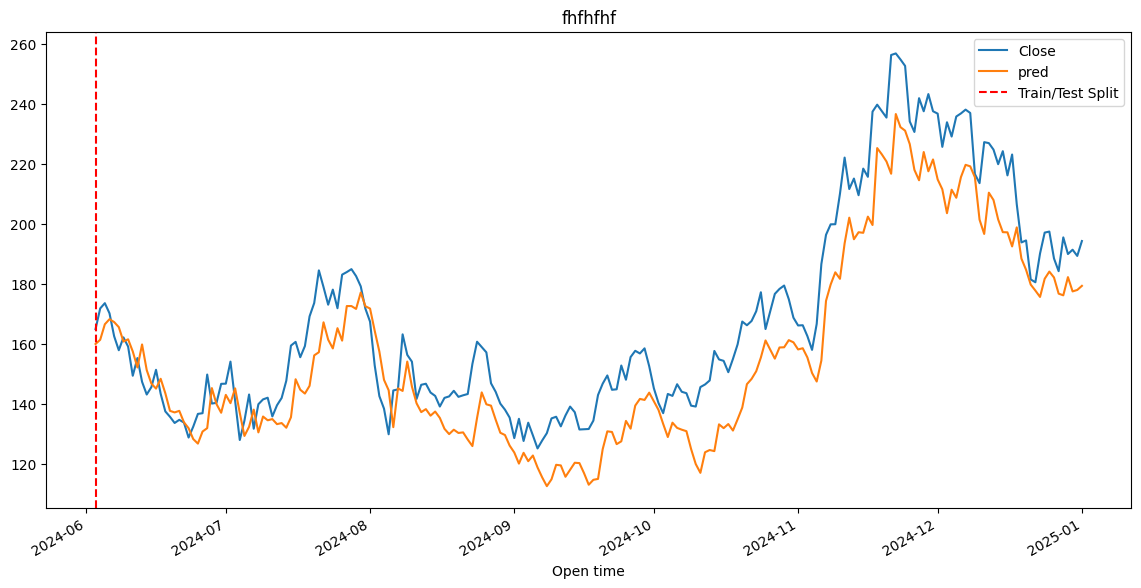

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

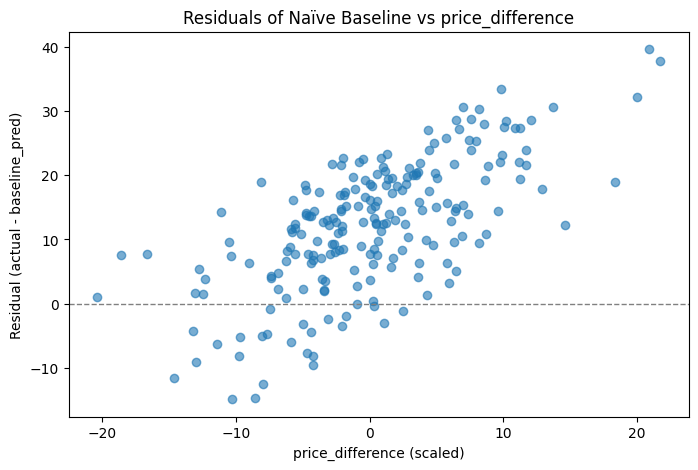

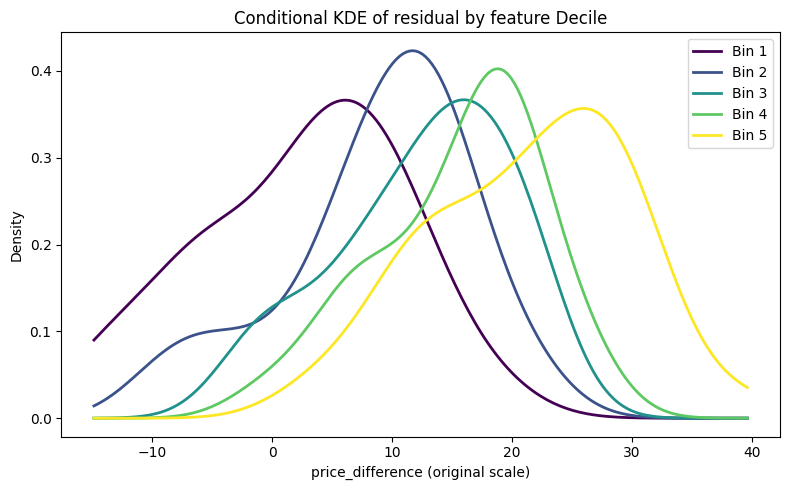

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)